In [ ]:
!pip install wandb

In [ ]:
import os
import math
import string
import random
import time
import wandb
import torch
import torch.nn as nn
from torch import optim
import matplotlib.pylab as plt
from tqdm import tqdm
import cv2
import numpy as np
import torchvision
from torchvision import transforms
from datetime import datetime
import csv
import pandas as pd
from glob import glob

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!mkdir './HTR_dataset'
!mkdir './HTR_dataset/test_journal'
!cp '/content/drive/MyDrive/JOURNAL_HCR_PROJECT/HTR_dataset/train.tsv' './HTR_dataset/train.tsv'
!cp '/content/drive/MyDrive/JOURNAL_HCR_PROJECT/HTR_dataset/test.tsv' './HTR_dataset/test.tsv'
!cp '/content/drive/MyDrive/JOURNAL_HCR_PROJECT/HTR_dataset/train_filtered.csv' './HTR_dataset/train_filtered.csv'
!cp '/content/drive/MyDrive/JOURNAL_HCR_PROJECT/HTR_dataset/chars_code.csv' './HTR_dataset/chars_code.csv'
!cp '/content/drive/MyDrive/JOURNAL_HCR_PROJECT/HTR_dataset/train.zip' './HTR_dataset/train.zip'
!cp '/content/drive/MyDrive/JOURNAL_HCR_PROJECT/HTR_dataset/test.zip' './HTR_dataset/test.zip'
!cp '/content/drive/MyDrive/JOURNAL_HCR_PROJECT/HTR_dataset/source.txt' './HTR_dataset/gen_source.txt'
!cp '/content/drive/MyDrive/JOURNAL_HCR_PROJECT/HTR_dataset/source_valid.txt' './HTR_dataset/gen_source_valid.txt'
!cp '/content/drive/MyDrive/JOURNAL_HCR_PROJECT/Names_test_dataset.zip' './HTR_dataset/test_journal.zip'
!cp '/content/drive/MyDrive/JOURNAL_HCR_PROJECT/Grades Dataset.zip' './HTR_dataset/grades_data.zip'
!unzip './HTR_dataset/train.zip' -d './HTR_dataset'
!unzip './HTR_dataset/test.zip' -d './HTR_dataset'
!unzip './HTR_dataset/test_journal.zip' -d './HTR_dataset'
!unzip './HTR_dataset/grades_data.zip' -d './HTR_dataset'

mkdir: cannot create directory ‘./HTR_dataset’: File exists
mkdir: cannot create directory ‘./HTR_dataset/test_journal’: File exists
Archive:  ./HTR_dataset/train.zip
replace ./HTR_dataset/train/rc3129.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: Archive:  ./HTR_dataset/test.zip
replace ./HTR_dataset/test/testt1118.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: Archive:  ./HTR_dataset/test_journal.zip
replace ./HTR_dataset/Names_test_dataset/file_target_mapping.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: Archive:  ./HTR_dataset/grades_data.zip
replace ./HTR_dataset/Grades Dataset/Test/2/3_9.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
WANDB_LOG = True
FINISH_TRAINING = False
GENERAL_RESULT_DIR = '/content/drive/MyDrive/JOURNAL_HCR_PROJECT/training_results/'

if FINISH_TRAINING:
    date_dirs_name = []
    for dir_name in os.listdir(GENERAL_RESULT_DIR):
        try:
            time.strptime(dir_name, '%Y-%m-%d_%H:%M:%S')
            date_dirs_name.append(dir_name)
        except ValueError:
            continue
    last_training_name = date_dirs_name[-1]
    RESULT_DIRECTORY = os.path.join(GENERAL_RESULT_DIR, last_training_name) 
else: 
    now = datetime.now()
    current_time = now.strftime('%Y-%m-%d_%H:%M:%S')
    RESULT_DIRECTORY = os.path.join(GENERAL_RESULT_DIR, current_time) 
    os.mkdir(RESULT_DIRECTORY)

RESULT_DIRECTORY

'/content/drive/MyDrive/JOURNAL_HCR_PROJECT/training_results/2022-04-25_09:51:23'


## UTILITY FUNCTIONS

In [ ]:
!pip install editdistance
import editdistance

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# text to array of indicies
def text_to_labels(s, char2idx):
    return [char2idx['SOS']] + [char2idx[i] for i in s if i in char2idx.keys()] + [char2idx['EOS']]

# convert images and labels into defined data structures
def process_data(image_dir, labels_dir, ignore=[], spliter = '\t'):
    """
    params
    ---
    image_dir : str
      path to directory with images
    labels_dir : str
      path to tsv file with labels
    returns
    ---
    img2label : dict
      keys are names of images and values are correspondent labels
    chars : list
      all unique chars used in data
    all_labels : list
    """

    chars = []
    img2label = dict()

    raw = open(labels_dir, 'r', encoding='utf-8').read()
    temp = raw.split('\n')
    for t in temp:
        try:
            x = t.split(spliter)
            flag = False
            for item in ignore:
                if item in x[1]:
                    flag = True
            if flag == False:
                img2label[image_dir + x[0]] = x[1]
                for char in x[1]:
                    if char not in chars:
                        chars.append(char)
        except:
            print('ValueError:', x)
            pass

    all_labels = sorted(list(set(list(img2label.values()))))
    chars.sort()
    chars = ['PAD', 'SOS'] + chars + ['EOS']

    return img2label, chars, all_labels

# MAKE TEXT TO BE THE SAME LENGTH
class TextCollate():
    def __call__(self, batch):
        x_padded = []
        max_y_len = max([i[1].size(0) for i in batch])
        y_padded = torch.LongTensor(max_y_len, len(batch))
        y_padded.zero_()

        for i in range(len(batch)):
            x_padded.append(batch[i][0].unsqueeze(0))
            y = batch[i][1]
            y_padded[:y.size(0), i] = y
        x_padded = torch.cat(x_padded)
        return x_padded, y_padded


# TRANSLATE INDICIES TO TEXT
def labels_to_text(s, idx2char):
    """
    params
    ---
    idx2char : dict
        keys : int
            indicies of characters
        values : str
            characters
    returns
    ---
    S : str
    """
    S = "".join([idx2char[i] for i in s])
    if S.find('EOS') == -1:  
        return S
    else:
        return S[:S.find('EOS')] 


# COMPUTE CHARACTER ERROR RATE
def char_error_rate(p_seq1, p_seq2):
    """
    params
    ---
    p_seq1 : str
    p_seq2 : str
    returns
    ---
    cer : float
    """
    p_vocab = set(p_seq1 + p_seq2)
    p2c = dict(zip(p_vocab, range(len(p_vocab)))) 
    c_seq1 = [chr(p2c[p]) for p in p_seq1]
    c_seq2 = [chr(p2c[p]) for p in p_seq2]
    return editdistance.eval(''.join(c_seq1),
                             ''.join(c_seq2)) / max(len(c_seq1), len(c_seq2))


def process_image(img):
    """
    params:
    ---
    img : np.array
    returns
    ---
    img : np.array
    """
    w, h, _ = img.shape
    new_w = hp.height
    new_h = int(h * (new_w / w))
    img = cv2.resize(img, (new_h, new_w))
    w, h, _ = img.shape

    img = img.astype('float32')

    new_h = hp.width
    if h < new_h:
        add_zeros = np.full((w, new_h - h, 3), 255)
        img = np.concatenate((img, add_zeros), axis=1)

    if h > new_h:
        img = cv2.resize(img, (new_h, new_w))

    return img


# GENERATE IMAGES FROM FOLDER
def generate_data(img_paths):
    """
    params
    ---
    names : list of str
        paths to images
    returns
    ---
    data_images : list of np.array
        images in np.array format
    """
    data_images = []
    for path in img_paths:
        img = cv2.imread(path)
        try:
            img = process_image(img)
            data_images.append(img.astype('uint8'))
        except:
            img = process_image(img)
    return data_images

def train(model, optimizer, criterion, iterator):
    """
    params
    ---
    model : nn.Module
    optimizer : nn.Object
    criterion : nn.Object
    iterator : torch.utils.data.DataLoader
    returns
    ---
    epoch_loss / len(iterator) : float
        overall loss
    """
    model.train()
    epoch_loss = 0
    counter = 0
    for src, trg in tqdm(iterator):
        counter += 1
        if counter % 500 == 0:
            print('[', counter, '/', len(iterator), ']')
        if torch.cuda.is_available():
          src, trg = src.cuda(), trg.cuda()

        optimizer.zero_grad()
        output = model(src, trg[:-1, :])

        loss = criterion(output.view(-1, output.shape[-1]), torch.reshape(trg[1:, :], (-1,)))
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    return epoch_loss / len(iterator)

def write_loss_to_csv(train_loss, val_loss, report_path):
    headersCSV = ['train_loss', 'val_loss']   

    if not os.path.isfile(report_path):
        with open(report_path, mode='w') as f:
            writer = csv.DictWriter(f, fieldnames=headersCSV)
            writer.writeheader()   

    loss_dict={'train_loss':train_loss,'val_loss':val_loss}

    with open(report_path, 'a', newline='') as f_object:
        dictwriter_object = csv.DictWriter(f_object, fieldnames=headersCSV)
        dictwriter_object.writerow(loss_dict)


# GENERAL FUNCTION FROM TRAINING AND VALIDATION
def train_all(model,optimizer,criterion,scheduler, train_loader, val_loader,epoch_limit):
    train_losses = []
    valid_losses = []
    report_file_path = os.path.join(RESULT_DIRECTORY, 'loss_report.csv')

    for epoch in range(0, epoch_limit):
        print(f'Epoch: {epoch + 1:02}')
        print("-----------train------------")
        train_loss = train(model, optimizer, criterion, train_loader)
        print("train loss :",train_loss)
        print("\n-----------valid------------")
        valid_loss = evaluate(model, criterion, val_loader)
        print("validation loss :",valid_loss)

        train_losses.append(train_loss)
        valid_losses.append(valid_loss)
        scheduler.step(valid_loss)

        torch.save(model.state_dict(), os.path.join(RESULT_DIRECTORY, 'htr_transformer.pth'))
        torch.save(optimizer.state_dict(), os.path.join(RESULT_DIRECTORY, 'optimizer.pth'))
        if epoch % 5 == 0:
          torch.save(model.state_dict(), os.path.join(GENERAL_RESULT_DIR, 'htr_transformer.pth'))

        write_loss_to_csv(train_loss, valid_loss, report_file_path)

        if WANDB_LOG:
            wandb.log({'Epoch': epoch})
            wandb.log({'Train Loss': train_loss})
            wandb.log({'Validation Loss': valid_loss})



    return train_losses, valid_losses


def validate(model, dataset, char2idx, idx2char):
    model.eval()
    show_count = 0
    wer_overall = 0
    cer_overall = 0
    with torch.no_grad():
        for (src, trg) in tqdm(dataset):
            src = src.unsqueeze(0)
            img = np.moveaxis(src[0].numpy(), 0, 2)
            if torch.cuda.is_available():
              src = src.cuda()

            out_indexes = [char2idx['SOS'], ]

            for i in range(100):
                
                trg_tensor = torch.LongTensor(out_indexes).unsqueeze(1).to(device)
                output = model(src,trg_tensor)
                out_token = output.argmax(2)[-1].item()
                out_indexes.append(out_token)
                if out_token == char2idx['EOS']:
                    break

            out_char = labels_to_text(out_indexes[1:], idx2char)
            real_char = labels_to_text(trg[1:].numpy(), idx2char)
            wer_overall += int(real_char != out_char)
            if out_char:
                cer = char_error_rate(real_char, out_char)
            else:
                cer = 1
            
            cer_overall += cer
            if WANDB_LOG and out_char != real_char:
                wandb.log({'Validation Character Accuracy': (1-cer)*100})
                wandb.log({"Validation Examples": wandb.Image(img, caption="Pred: {} Truth: {}".format(out_char, real_char))})
                show_count += 1
    
    return cer_overall / len(dataset) * 100, wer_overall / len(dataset) * 100

def evaluate(model, criterion, iterator):
      """
      params
      ---
      model : nn.Module
      criterion : nn.Object
      iterator : torch.utils.data.DataLoader
      returns
      ---
      epoch_loss / len(iterator) : float
          overall loss
      """
      model.eval()
      epoch_loss = 0
      with torch.no_grad():
          for (src, trg) in tqdm(iterator):
              src, trg = src.cuda(), trg.cuda()
              output = model(src, trg[:-1, :])
              loss = criterion(output.view(-1, output.shape[-1]), torch.reshape(trg[1:, :], (-1,)))
              epoch_loss += loss.item()
      return epoch_loss / len(iterator)

# SPLIT DATASET INTO TRAIN AND VALID PARTS
def train_valid_split(img2label, val_part=0.3):
    """
    params
    ---
    img2label : dict
        keys are paths to images, values are labels (transcripts of crops)
    returns
    ---
    imgs_val : list of str
        paths
    labels_val : list of str
        labels
    imgs_train : list of str
        paths
    labels_train : list of str
        labels
    """

    imgs_val, labels_val = [], []
    imgs_train, labels_train = [], []

    N = int(len(img2label) * val_part)
    items = list(img2label.items())
    random.shuffle(items)
    for i, item in enumerate(items):
        if i < N:
            imgs_val.append(item[0])
            labels_val.append(item[1])
        else:
            imgs_train.append(item[0])
            labels_train.append(item[1])
    print('valid part:{}'.format(len(imgs_val)))
    print('train part:{}'.format(len(imgs_train)))
    return imgs_val, labels_val, imgs_train, labels_train


def prediction(model, test_dir, img2label, char2idx, idx2char, show_result = False):
    preds = {}
    model.eval()
    with torch.no_grad():
        preds = {}
        for img_path, target_str in tqdm(img2label.items()):
            img = generate_data([img_path])[0]
            transform = transforms.Compose([
              #transforms.ToPILImage(),
              transforms.ToTensor(),
              transforms.Normalize((0.5,), (0.5,))])
            norm_img = transform(img)

            src = torch.FloatTensor(norm_img).unsqueeze(0).to(device)
            out_indexes = [char2idx['SOS'], ]

            for i in range(100):
                trg_tensor = torch.LongTensor(out_indexes).unsqueeze(1).to(device)
                output = model(src,trg_tensor)
                out_token = output.argmax(2)[-1].item()
                out_indexes.append(out_token)
                if out_token == char2idx['EOS']:
                    break

            pred = labels_to_text(out_indexes[1:], idx2char)
            preds[img_path] = pred

            if show_result:
                print("File name: {} Predict: {} True: {}".format(img_path, pred, target_str))
                plt.imshow(img)
                plt.show()
        
        return preds

## CONFIG

In [ ]:
class Hparams():
    def __init__(self):

        # SETS OF CHARACTERS
        self.cyrillic = ['PAD', 'SOS', ' ', '!', '"', '%', '(', ')', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '?', '[', ']', '«', '»', 'А', 'Б', 'В', 'Г', 'Д', 'Е', 'Ж', 'З', 'И', 'Й', 'К', 'Л', 'М', 'Н', 'О', 'П', 'Р', 'С', 'Т', 'У', 'Ф', 'Х', 'Ц', 'Ч', 'Ш', 'Щ', 'Э', 'Ю', 'Я', 'а', 'б', 'в', 'г', 'д', 'е', 'ж', 'з', 'и', 'й', 'к', 'л', 'м', 'н', 'о', 'п', 'р', 'с', 'т', 'у', 'ф', 'х', 'ц', 'ч', 'ш', 'щ', 'ъ', 'ы', 'ь', 'э', 'ю', 'я', 'ё', 'EOS']
        # CHARS TO REMOVE
        self.del_sym = []

        self.lr = 0.0002
        self.batch_size = 64
        self.hidden = 512
        self.enc_layers = 2
        self.dec_layers = 2
        self.nhead = 4
        self.dropout = 0.0
        
        # IMAGE SIZE
        self.width = 256
        self.height = 64

class Paths():
    def __init__(self):
        self.PATH_TEST_DIR = "./HTR_dataset/test"
        self.PATH_TEST_LABELS = "./HTR_dataset/test.tsv"
        #txt file with pretrain expressions for handwritting generator
        self.PATH_TO_SOURCE = './HTR_dataset/gen_source.txt'
        # txt file with validation expressions for handwritting generator
        self.PATH_TO_SOURCE_VALID = './HTR_dataset/gen_source_valid.txt'
        # path where pretrain images will be stored during training
        self.PATH_TEMP = './pretrain/temp/'
        # path where validation images will be stored during training
        self.PATH_TEMP_VALID = "./pretrain/temp_valid/"


random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

hp = Hparams()
path = Paths()

# CREATE MAPS FROM CHARACTERS TO INDICIES AND VISA VERSA
char2idx = {char: idx for idx, char in enumerate(hp.cyrillic)}
idx2char = {idx: char for idx, char in enumerate(hp.cyrillic)}

## TRANSFORMER MODEL

In [ ]:
from torchvision import models
class TransformerModel(nn.Module):
    def __init__(self, bb_name, outtoken, hidden, enc_layers=1, dec_layers=1, nhead=1, dropout=0.1, pretrained=False):
        super(TransformerModel, self).__init__()
        self.backbone = models.__getattribute__(bb_name)(pretrained=pretrained)
        self.backbone.fc = nn.Conv2d(2048, int(hidden/2), 1)

        self.pos_encoder = PositionalEncoding(hidden, dropout)
        self.decoder = nn.Embedding(outtoken, hidden)
        self.pos_decoder = PositionalEncoding(hidden, dropout)
        self.transformer = nn.Transformer(d_model=hidden, nhead=nhead, num_encoder_layers=enc_layers,
                                          num_decoder_layers=dec_layers, dim_feedforward=hidden * 4, dropout=dropout,
                                          activation='relu')

        self.fc_out = nn.Linear(hidden, outtoken)
        self.src_mask = None
        self.trg_mask = None
        self.memory_mask = None
        
        print('backbone: {}'.format(type(self.backbone)))
        print('layers: {}'.format(enc_layers))
        print('heads: {}'.format(nhead))
        print('dropout: {}'.format(dropout))
        print(f'{count_parameters(self):,} trainable parameters')

    def generate_square_subsequent_mask(self, sz):
        mask = torch.triu(torch.ones(sz, sz), 1)
        mask = mask.masked_fill(mask == 1, float('-inf'))
        return mask

    def make_len_mask(self, inp):
        return (inp == 0).transpose(0, 1)

    def forward(self, src, trg):
        '''
        params
        ---
        src : Tensor [64, 3, 64, 256] : [B,C,H,W]
            B - batch, C - channel, H - height, W - width
        trg : Tensor [13, 64] : [L,B]
            L - max length of label
        '''
        if self.trg_mask is None or self.trg_mask.size(0) != len(trg):
            self.trg_mask = self.generate_square_subsequent_mask(len(trg)).to(trg.device) 
        x = self.backbone.conv1(src)

        x = self.backbone.bn1(x)
        x = self.backbone.relu(x)
        x = self.backbone.maxpool(x)
        x = self.backbone.layer1(x)
        x = self.backbone.layer2(x)
        x = self.backbone.layer3(x)
        x = self.backbone.layer4(x) # [64, 2048, 2, 8] : [B,C,H,W]
            
        x = self.backbone.fc(x) # [64, 256, 2, 8] : [B,C,H,W]
        x = x.permute(0, 3, 1, 2) # [64, 8, 256, 2] : [B,W,C,H]
        x = x.flatten(2) # [64, 8, 512] : [B,W,CH]
        x = x.permute(1, 0, 2) # [8, 64, 512] : [W,B,CH]
        
        src_pad_mask = self.make_len_mask(x[:, :, 0])
        src = self.pos_encoder(x) # [8, 64, 512]
        trg_pad_mask = self.make_len_mask(trg)
        trg = self.decoder(trg)
        trg = self.pos_decoder(trg)

        output = self.transformer(src, trg, src_mask=self.src_mask, tgt_mask=self.trg_mask,
                                  memory_mask=self.memory_mask,
                                  src_key_padding_mask=src_pad_mask, tgt_key_padding_mask=trg_pad_mask,
                                  memory_key_padding_mask=src_pad_mask) # [13, 64, 512] : [L,B,CH]
        output = self.fc_out(output) # [13, 64, 92] : [L,B,H]

        return output

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        self.scale = nn.Parameter(torch.ones(1))

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(
            0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.scale * self.pe[:x.size(0), :]
        return self.dropout(x) 

In [ ]:
model = TransformerModel('resnet50', len(hp.cyrillic), hidden=hp.hidden, enc_layers=3, dec_layers=3, nhead=8, dropout=0.0).to(device)
if FINISH_TRAINING: 
    model.load_state_dict(torch.load(os.path.join(RESULT_DIRECTORY, 'htr_transformer.pth')))

# model.load_state_dict(torch.load('/content/drive/MyDrive/JOURNAL_HCR_PROJECT/ocr_transformer_rn50_64x256_53str_jit.pt')['model'])

backbone: <class 'torchvision.models.resnet.ResNet'>
layers: 3
heads: 8
dropout: 0.0
46,198,174 trainable parameters


## DATASET CLASS

In [ ]:
# store list of images' names (in directory) and does some operations with images
class TextLoader(torch.utils.data.Dataset):
    def __init__(self, images_name, labels, char2idx, idx2char, eval=False):
        """
        params
        ---
        images_name : list
            list of names of images (paths to images)
        labels : list
            list of labels to correspondent images from images_name list
        char2idx : dict
        idx2char : dict
        """
        self.images_name = images_name
        self.labels = labels
        self.char2idx = char2idx
        self.idx2char = idx2char
        self.eval = eval
        self.transform = transforms.Compose([
            transforms.ToPILImage(),
            #transforms.Resize((int(hp.height *1.05), int(hp.width *1.05))),
            #transforms.RandomCrop((hp.height, hp.width)),
            # transforms.ColorJitter(contrast=(0.5,1),saturation=(0.5,1)),
            # transforms.RandomRotation(degrees=(-9, 9), fill=255),
            # transforms.RandomAffine(10 ,None ,[0.6 ,1] ,3 ,fillcolor=255),
            # transforms.transforms.GaussianBlur(3, sigma=(0.1, 1.9)),
            transforms.ToTensor(),
            transforms.Normalize((0.5,), (0.5,))
        ])

    def _transform(self, X):
        return self.transform(X)
        
    def __getitem__(self, index):
        img = self.images_name[index]
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = self.transform(img)
        #img = np.transpose(img, (2, 0, 1))


        label = text_to_labels(self.labels[index], self.char2idx)
        return (torch.FloatTensor(img), torch.LongTensor(label))

    def __len__(self):
        return len(self.labels)

## TRAIN


In [ ]:
img2label, _, _ = process_data('/content/HTR_dataset/train/', '/content/HTR_dataset/train_filtered.csv')
chars = hp.cyrillic

X_val, y_val, X_train, y_train = train_valid_split(img2label,val_part=0.1)

ValueError: ['']
valid part:3157
train part:28421


In [ ]:
X_train = generate_data(X_train)
X_val = generate_data(X_val)

train_dataset = TextLoader(X_train, y_train, char2idx ,idx2char, eval=False)
train_loader = torch.utils.data.DataLoader(train_dataset, shuffle=True,
                                           batch_size=hp.batch_size, pin_memory=True,
                                           drop_last=True, collate_fn=TextCollate())

val_dataset = TextLoader(X_val, y_val, char2idx,idx2char, eval=True)
val_loader = torch.utils.data.DataLoader(val_dataset, shuffle=False,
                                         batch_size=1, pin_memory=False,
                                         drop_last=False, collate_fn=TextCollate())
    

In [ ]:
#optimizer = optim.SGD(model.parameters(), lr=hp.lr)
optimizer = torch.optim.AdamW(model.parameters(), lr=hp.lr, weight_decay=0.01)
criterion = nn.CrossEntropyLoss(ignore_index=char2idx['PAD'])
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')

In [ ]:
if WANDB_LOG:
    wandb.init(project="OCR-transformer", config={
        "learning_rate":hp.lr,
        "dropout": hp.dropout,
        "batch_size": hp.batch_size,
        "architecture": "RESNET50 + TRANSFORMER",
        "dataset": "64x512 train 29k",
        "classes": "92",
    })
    config = wandb.config

wandb: Currently logged in as: igor_dor (use `wandb login --relogin` to force relogin)


In [ ]:
train_losses, val_losses = train_all(model, optimizer, criterion, scheduler,train_loader,val_loader, epoch_limit=80)

Epoch: 01
-----------train------------


100%|██████████| 444/444 [08:24<00:00,  1.14s/it]


train loss : 2.4355247823504715

-----------valid------------


100%|██████████| 3157/3157 [03:28<00:00, 15.15it/s]


validation loss : 2.10743188335052
Epoch: 02
-----------train------------


100%|██████████| 444/444 [08:25<00:00,  1.14s/it]


train loss : 1.901161899706265

-----------valid------------


100%|██████████| 3157/3157 [03:28<00:00, 15.12it/s]


validation loss : 1.8231487366588273
Epoch: 03
-----------train------------


100%|██████████| 444/444 [08:24<00:00,  1.14s/it]


train loss : 1.6179663487919815

-----------valid------------


100%|██████████| 3157/3157 [03:28<00:00, 15.11it/s]


validation loss : 1.6602864330484024
Epoch: 04
-----------train------------


100%|██████████| 444/444 [08:25<00:00,  1.14s/it]


train loss : 1.3492795279971115

-----------valid------------


100%|██████████| 3157/3157 [03:30<00:00, 14.98it/s]


validation loss : 1.4049279251674855
Epoch: 05
-----------train------------


100%|██████████| 444/444 [08:24<00:00,  1.14s/it]


train loss : 1.1098988163578618

-----------valid------------


100%|██████████| 3157/3157 [03:28<00:00, 15.14it/s]


validation loss : 1.154649820167537
Epoch: 06
-----------train------------


100%|██████████| 444/444 [08:25<00:00,  1.14s/it]


train loss : 0.8776386215074642

-----------valid------------


100%|██████████| 3157/3157 [03:29<00:00, 15.07it/s]


validation loss : 0.9766357064802916
Epoch: 07
-----------train------------


100%|██████████| 444/444 [08:24<00:00,  1.14s/it]


train loss : 0.6865028571169656

-----------valid------------


100%|██████████| 3157/3157 [03:28<00:00, 15.16it/s]


validation loss : 0.8709907138691835
Epoch: 08
-----------train------------


100%|██████████| 444/444 [08:25<00:00,  1.14s/it]


train loss : 0.5468173868081592

-----------valid------------


100%|██████████| 3157/3157 [03:28<00:00, 15.16it/s]


validation loss : 0.8311248927073754
Epoch: 09
-----------train------------


100%|██████████| 444/444 [08:24<00:00,  1.14s/it]


train loss : 0.478352596966533

-----------valid------------


100%|██████████| 3157/3157 [03:29<00:00, 15.07it/s]


validation loss : 0.7666495553992431
Epoch: 10
-----------train------------


100%|██████████| 444/444 [08:24<00:00,  1.14s/it]


train loss : 0.38458972417556486

-----------valid------------


100%|██████████| 3157/3157 [03:28<00:00, 15.16it/s]


validation loss : 0.6570676807478529
Epoch: 11
-----------train------------


100%|██████████| 444/444 [08:24<00:00,  1.14s/it]


train loss : 0.30200508418115407

-----------valid------------


100%|██████████| 3157/3157 [03:27<00:00, 15.19it/s]


validation loss : 0.661904131097872
Epoch: 12
-----------train------------


100%|██████████| 444/444 [08:24<00:00,  1.14s/it]


train loss : 0.2620141333019411

-----------valid------------


100%|██████████| 3157/3157 [03:26<00:00, 15.26it/s]


validation loss : 0.6451177893789733
Epoch: 13
-----------train------------


100%|██████████| 444/444 [08:24<00:00,  1.14s/it]


train loss : 0.25727042052391413

-----------valid------------


100%|██████████| 3157/3157 [03:29<00:00, 15.09it/s]


validation loss : 0.6711202346100149
Epoch: 14
-----------train------------


100%|██████████| 444/444 [08:25<00:00,  1.14s/it]


train loss : 0.20726172820673333

-----------valid------------


100%|██████████| 3157/3157 [03:29<00:00, 15.07it/s]


validation loss : 0.6807874329467677
Epoch: 15
-----------train------------


100%|██████████| 444/444 [08:24<00:00,  1.14s/it]


train loss : 0.22307389053339893

-----------valid------------


100%|██████████| 3157/3157 [03:29<00:00, 15.07it/s]


validation loss : 0.7400448054661485
Epoch: 16
-----------train------------


100%|██████████| 444/444 [08:23<00:00,  1.13s/it]


train loss : 0.17645682270328203

-----------valid------------


100%|██████████| 3157/3157 [03:29<00:00, 15.08it/s]


validation loss : 0.6002992555923417
Epoch: 17
-----------train------------


100%|██████████| 444/444 [08:24<00:00,  1.14s/it]


train loss : 0.13466224502268676

-----------valid------------


100%|██████████| 3157/3157 [03:29<00:00, 15.10it/s]


validation loss : 0.6466103661932565
Epoch: 18
-----------train------------


100%|██████████| 444/444 [08:24<00:00,  1.14s/it]


train loss : 0.12547406981288045

-----------valid------------


100%|██████████| 3157/3157 [03:29<00:00, 15.09it/s]


validation loss : 0.5919573273538794
Epoch: 19
-----------train------------


100%|██████████| 444/444 [08:23<00:00,  1.13s/it]


train loss : 0.14367145304945675

-----------valid------------


100%|██████████| 3157/3157 [03:29<00:00, 15.06it/s]


validation loss : 0.5624046639992045
Epoch: 20
-----------train------------


100%|██████████| 444/444 [08:24<00:00,  1.14s/it]


train loss : 0.09765477199946437

-----------valid------------


100%|██████████| 3157/3157 [03:29<00:00, 15.07it/s]


validation loss : 0.5844099698786733
Epoch: 21
-----------train------------


100%|██████████| 444/444 [08:24<00:00,  1.14s/it]


train loss : 0.1401142020718203

-----------valid------------


100%|██████████| 3157/3157 [03:29<00:00, 15.09it/s]


validation loss : 0.6854810732034909
Epoch: 22
-----------train------------


100%|██████████| 444/444 [08:24<00:00,  1.14s/it]


train loss : 0.16631623298802353

-----------valid------------


100%|██████████| 3157/3157 [03:29<00:00, 15.05it/s]


validation loss : 0.5868267043221573
Epoch: 23
-----------train------------


100%|██████████| 444/444 [08:24<00:00,  1.14s/it]


train loss : 0.1883487201438428

-----------valid------------


100%|██████████| 3157/3157 [03:29<00:00, 15.06it/s]


validation loss : 0.7459300156192804
Epoch: 24
-----------train------------


100%|██████████| 444/444 [08:24<00:00,  1.14s/it]


train loss : 0.2717017985477641

-----------valid------------


100%|██████████| 3157/3157 [03:29<00:00, 15.04it/s]


validation loss : 0.6602943539414731
Epoch: 25
-----------train------------


100%|██████████| 444/444 [08:24<00:00,  1.14s/it]


train loss : 0.1279346222930529

-----------valid------------


100%|██████████| 3157/3157 [03:29<00:00, 15.10it/s]


validation loss : 0.5521088271756119
Epoch: 26
-----------train------------


 68%|██████▊   | 300/444 [05:40<02:42,  1.13s/it]

In [ ]:
plt.plot(train_losses, label='train')
plt.plot(val_losses, label='validation')

plt.legend()
plt.show()

##Journal Train

In [ ]:
img2label, _, _ = process_data('/content/HTR_dataset/Names_test_dataset/', '/content/HTR_dataset/Names_test_dataset/file_target_mapping.txt', spliter = ',')
chars = hp.cyrillic
_, _, X_train, y_train = train_valid_split(img2label,val_part=0)
X_train = generate_data(X_train)
names_dataset = TextLoader(X_train, y_train, char2idx ,idx2char, eval=False)

ValueError: ['']
valid part:0
train part:403


In [ ]:
TRAIN_DATA_PATH = '/content/HTR_dataset/Grades Dataset/Train'

def change_target(target_idx):
    labels_mapp = ['2',  '3',  '4',  '5',  '',  'н']
    label = text_to_labels(labels_mapp[target_idx], char2idx)
    return torch.LongTensor(label)

transform = transforms.Compose([
                transforms.Lambda(lambda x: np.asarray(x.convert('RGB'))),
                transforms.Lambda(process_image),
                #transforms.Resize((64, 256)),
                transforms.Lambda(lambda x: x.astype('uint8')),
                transforms.ToPILImage(),
                transforms.ToTensor(),
                transforms.Normalize((0.5,), (0.5,))])

grades_dataset = torchvision.datasets.ImageFolder(root=TRAIN_DATA_PATH, transform=transform, target_transform=change_target)

In [ ]:
class ConcatDataset(torch.utils.data.Dataset):
    def __init__(self, names_dataset, grades_dataset):
        self.names_dataset = names_dataset
        self.grades_dataset = grades_dataset
        self.shuffled_grades = self.regenerate_grades_data()
    
    def regenerate_grades_data(self):
        random_idxs = random.sample(range(1, len(self.grades_dataset)), int(len(self.grades_dataset)*0.7))
        shuffled_grades = []
        for i in random_idxs:
            shuffled_grades.append(self.grades_dataset[i])

        return shuffled_grades

    def __getitem__(self, i):
        if i < len(self.names_dataset):
            return self.names_dataset[i][0], self.names_dataset[i][1]
        else:
            names_data_len  = len(self.names_dataset)
            return self.shuffled_grades[i - names_data_len]

    def __len__(self):
        lenght = len(self.names_dataset) + len(self.shuffled_grades)
        return lenght

mix_journal_dataset = ConcatDataset(
                 names_dataset,
                 grades_dataset
             )
             
mix_journal_dataset_train, mix_journal_dataset_val = torch.utils.data.random_split(mix_journal_dataset, [int(len(mix_journal_dataset)*0.8), int(len(mix_journal_dataset)*0.2)])

mix_journal_loader_train = torch.utils.data.DataLoader(
             mix_journal_dataset_train,
             batch_size=64, shuffle=True,
             num_workers=2, collate_fn = TextCollate())

mix_journal_loader_val = torch.utils.data.DataLoader(
             mix_journal_dataset_val,
             batch_size=8, shuffle=True,
             num_workers=2, collate_fn = TextCollate())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


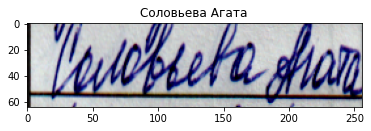

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


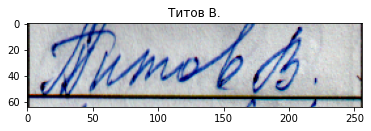

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


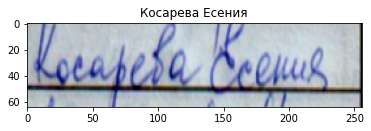

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


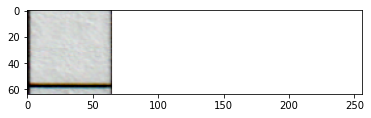

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


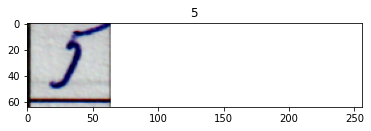

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


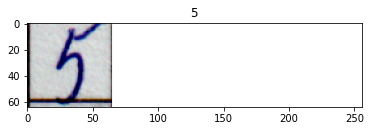

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


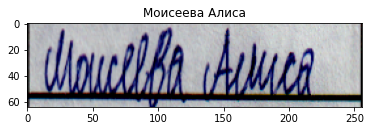

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


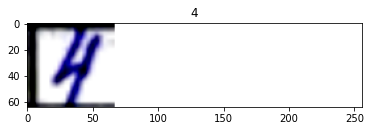

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


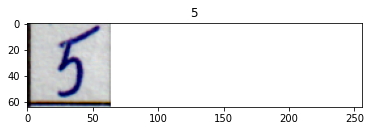

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


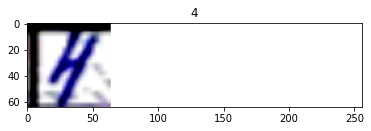

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


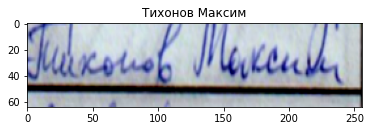

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


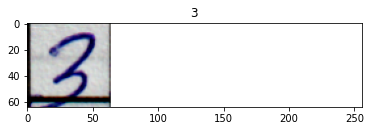

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


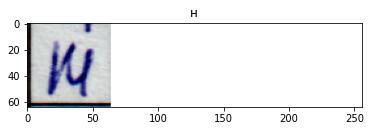

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


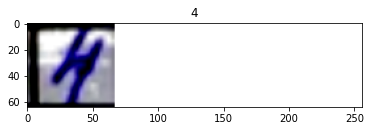

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


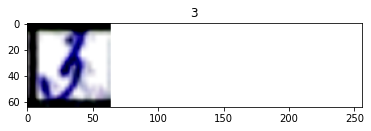

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


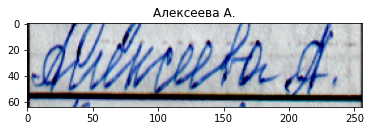

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


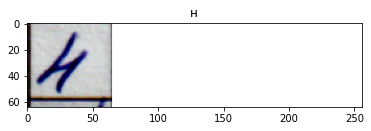

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


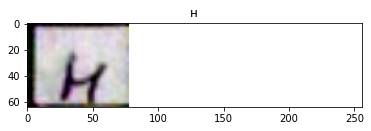

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


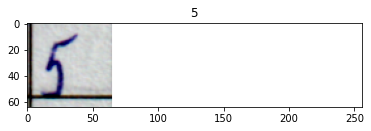

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


KeyboardInterrupt: ignored

In [ ]:
for img, label in mix_journal_dataset_train:
    plt.imshow(img.permute(1,2,0))
    char_labels = [char_label.item() for char_label in label[1:]]
    plt.title(labels_to_text(char_labels, idx2char))
    plt.show()

In [ ]:
# X_train = generate_data(X_train)
# X_val = generate_data(X_val)

# train_dataset = TextLoader(X_train, y_train, char2idx ,idx2char, eval=False)
# train_loader = torch.utils.data.DataLoader(train_dataset, shuffle=True,
#                                            batch_size=hp.batch_size, pin_memory=True,
#                                            drop_last=True, collate_fn=TextCollate())

# val_dataset = TextLoader(X_val, y_val, char2idx,idx2char, eval=True)
# val_loader = torch.utils.data.DataLoader(val_dataset, shuffle=False,
#                                          batch_size=1, pin_memory=False,
#                                          drop_last=False, collate_fn=TextCollate())

In [ ]:
train_losses, val_losses = train_all(model, optimizer, criterion, scheduler, mix_journal_loader_train, mix_journal_loader_val, epoch_limit=150)

Epoch: 01
-----------train------------
train loss : 0.9598485454916954

-----------valid------------


100%|██████████| 32/32 [00:03<00:00,  9.81it/s]


validation loss : 0.6963693480938673
Epoch: 02
-----------train------------
train loss : 0.26702627539634705

-----------valid------------


100%|██████████| 32/32 [00:03<00:00,  9.81it/s]


validation loss : 0.5608725931961089
Epoch: 03
-----------train------------


KeyboardInterrupt: ignored

## TEST

In [ ]:
model.load_state_dict(torch.load('/content/drive/MyDrive/JOURNAL_HCR_PROJECT/training_results/2022-04-12_11:21:49/htr_transformer.pth'))

<All keys matched successfully>

In [ ]:
img2label, _, _ = process_data('/content/HTR_dataset/Names_test_dataset/test/', '/content/HTR_dataset/Names_test_dataset/test/test_target_mapping.txt', spliter = ',')
chars = hp.cyrillic
_, _, X_test, y_test = train_valid_split(img2label,val_part=0)
X_test = generate_data(X_test)
names_dataset_test = TextLoader(X_test, y_test, char2idx ,idx2char, eval=False)

valid part:0
train part:42


In [ ]:
cer, wer = validate(model, names_dataset_test, char2idx, idx2char)
print(cer, wer)

100%|██████████| 42/42 [00:08<00:00,  5.03it/s]

9.971473826515846 57.14285714285714


In [ ]:
cer, wer = validate(model, names_dataset, char2idx, idx2char)
print(cer, wer)

100%|██████████| 403/403 [04:20<00:00,  1.55it/s]

1.9739688610156996 9.925558312655088


In [ ]:
cer, wer = validate(model, grades_dataset, char2idx, idx2char)
print(cer, wer)

100%|██████████| 1247/1247 [02:05<00:00,  9.97it/s]

8.660785886126703 0.32076984763432237


In [ ]:
cer, wer = validate(model, mix_journal_dataset_val, char2idx, idx2char)
print(cer, wer)

100%|██████████| 255/255 [01:14<00:00,  3.42it/s]

6.060974588656249 7.0588235294117645


In [ ]:
def test(model, test_dir, img_target_mapping_path, char2idx, idx2char, spliter, print_results = True, case=True, punct=False):
    img2label = dict()
    raw = open(img_target_mapping_path, 'r', encoding='utf-8').read()
    temp = raw.split('\n')
    for t in temp:
        if not spliter:
            x = t.split('\t')
        else: 
            x = t.split(spliter)
        img2label[os.path.join(test_dir, x[0])] = x[1]
    
    preds = prediction(model, test_dir, img2label, char2idx, idx2char)        
    N = len(preds)

    wer = 0
    cer = 0

    for item in preds.items():
        img_name = item[0]
        true_trans = img2label[os.path.join(test_dir, img_name)]
        predicted_trans = item[1]

        if 'ё' in true_trans:
            true_trans = true_trans.replace('ё', 'е')
        if 'ё' in predicted_trans:
            predicted_trans = predicted_trans.replace('ё', 'е')

        if not case:
            true_trans = true_trans.lower()
            predicted_trans = predicted_trans.lower()

        if not punct:
            true_trans = true_trans.translate(str.maketrans('', '', string.punctuation))
            predicted_trans = predicted_trans.translate(str.maketrans('', '', string.punctuation))

        if true_trans != predicted_trans and print_results:
            print('true:', true_trans)
            print('predicted:', predicted_trans)
            print('cer:', char_error_rate(predicted_trans, true_trans))
            print('---')
            wer += 1
            cer += char_error_rate(predicted_trans, true_trans)

    character_accuracy = 1 - cer / N
    string_accuracy = 1 - (wer / N)
    return character_accuracy, string_accuracy

In [ ]:
word_accur, char_accur = test(model, '/content/HTR_dataset/Names_test_dataset', 
                              '/content/HTR_dataset/Names_test_dataset/file_target_mapping.txt', 
                              char2idx, idx2char, spliter = ',', print_results = True, 
                              case=True, punct=True)
print(word_accur, char_accur)

100%|██████████| 300/300 [03:13<00:00,  1.55it/s]


true: лаврусина ю
predicted: авруктинать
cer: 0.45454545454545453
---
true: маречкина л
predicted: мароченная
cer: 0.45454545454545453
---
true: подольская а
predicted: подольская
cer: 0.16666666666666666
---
true: семугикин а
predicted: сескулителена
cer: 0.6153846153846154
---
true: суходолев г
predicted: суходолову
cer: 0.2727272727272727
---
true: терехина ю
predicted: терестома то
cer: 0.5
---
true: ухавов серг
predicted: пухабов серг
cer: 0.16666666666666666
---
true: фомин алдр
predicted: дом ин бля рф
cer: 0.46153846153846156
---
true: хуснердинов
predicted: хустирдинов
cer: 0.18181818181818182
---
true: успанина о
predicted: цепанинов
cer: 0.5
---
true: авдеев денис
predicted: андеев дении
cer: 0.16666666666666666
---
true: безденежных
predicted: будененных
cer: 0.2727272727272727
---
true: пелькина е
predicted: поськина 6
cer: 0.3
---
true: андреева д
predicted: амодрева аа
cer: 0.45454545454545453
---
true: гембарук иг
predicted: гелебарух и
cer: 0.36363636363636365
---
true

In [ ]:
word_accur, char_accur = test(model, '/content/HTR_dataset/test', 
                              '/content/HTR_dataset/test.tsv', 
                              char2idx, idx2char, spliter = '\t')
print(word_accur, char_accur)

100%|██████████| 1544/1544 [12:37<00:00,  2.04it/s]


Streaming output truncated to the last 5000 lines.
predicted: Студенна удаль
cer: 0.35294117647058826
---
true: доброжелательно
predicted: дорожела тельно
cer: 0.13333333333333333
---
true: требовательные
predicted: требова Мельные
cer: 0.13333333333333333
---
true: Наталье
predicted: Невисалья
cer: 0.5555555555555556
---
true: срок
predicted: Срок
cer: 0.25
---
true: Ивановы
predicted: 2
cer: 1.0
---
true: смогла
predicted: Слегогла
cer: 0.5
---
true: с детьми
predicted: С дельмер
cer: 0.4444444444444444
---
true: психологическим
predicted: Ксихологиселския
cer: 0.25
---
true: Сделаем
predicted: Семаем
cer: 0.2857142857142857
---
true: индивидуально
predicted: Индивиду Ан
cer: 0.38461538461538464
---
true: их
predicted: н
cer: 1.0
---
true: особенности
predicted: Осебенисе гениз
cer: 0.6666666666666666
---
true: учитывая
predicted: 4 ильегвая Егря
cer: 0.7333333333333333
---
true: индивидуальные
predicted: Индив 5замыев
cer: 0.5714285714285714
---
true: воздействия
predicted: Коздейст

In [ ]:
1 - 0.03367

0.96633